In [1]:
import numpy as np
import lysis
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import BoundaryNorm, ListedColormap

In [2]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code="2023-01-18-1600")
e.read_file()
file_code = ".f-normal.dat"

In [3]:
print(e)

experiment_code : 2023-01-18-1600
data_filenames  : unbinding_time    : tsectPA.dat
                  lysis_time        : lysismat.dat
                  total_lyses       : lenlysisvect.dat
                  degradation_state : deg.dat
micro_params    : None
macro_params    : binding_rate       : 0.1
                  pore_size          : 0.00010135
                  diffusion_coeff    : 5e-07
                  binding_sites      : 427
                  forced_unbind      : 0.0852
                  average_bind_time  : 27.8
                  grid_node_distance : 1.0862
                  cols               : 93
                  rows               : 121
                  full_row           : 278
                  xz_row             : 185
                  total_edges        : 33,545
                  total_fibers       : 25,761
                  empty_rows         : 28
                  last_empty_edge    : 7,783
                  total_molecules    : 43,074
                  moving_pro

In [4]:
deg = np.fromfile(os.path.join(e.os_path, "deg" + file_code))
tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))
mfpt = np.fromfile(os.path.join(e.os_path, "mfpt" + file_code))
deg = deg.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_edges)
tsave = tsave.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves)

In [5]:
mapped_deg = -deg
mapped_deg[deg == 0] = float('inf')
mapped_deg[deg == -1] = 0

In [6]:
exposed_time = np.empty((e.macro_params.total_trials, e.macro_params.rows-1, e.macro_params.cols), 
                        dtype=np.float_)
for run in range(e.macro_params.total_trials):
    for j in range(e.macro_params.cols):
        for i in range(e.macro_params.rows-1):
            if i == 0:
                exposed_time[run, i, j] = 0;
            else:
                k = lysis.to_fortran_edge_index(i, j, e.macro_params.rows, e.macro_params.cols)
                exposed_time[run, i, j] = max(exposed_time[run, i-1, j], mapped_deg[run, e.macro_params.number_of_saves-1, k])
#exposed_time = 10* np.ceil(exposed_time / 10)
exposed_time = exposed_time / 60

In [7]:
y_distance = np.arange(e.macro_params.rows-1)*e.macro_params.grid_node_distance 

In [8]:
deg_fronts = []
for r in range(e.macro_params.total_trials):
    run_deg_fronts = []
    for j in range(e.macro_params.cols):
        col_deg_front = []
        for i in range(1,e.macro_params.rows-1):
            if exposed_time[r, i, j] > exposed_time[r, i-1, j]:
                col_deg_front.append([exposed_time[r, i, j], y_distance[i]])
        run_deg_fronts.append(np.array(col_deg_front).T)
    deg_fronts.append(run_deg_fronts)

In [9]:
run_mean_velocity = np.empty(e.macro_params.total_trials, dtype=np.float_)
run_std_velocity = np.empty(e.macro_params.total_trials, dtype=np.float_)
for run in range(e.macro_params.total_trials):
    front_velocity = np.empty(e.macro_params.cols, dtype=np.float_)
    for j in range(e.macro_params.cols):
        b, m = np.polynomial.polynomial.polyfit(deg_fronts[run][j][0], deg_fronts[run][j][1], 1)
        front_velocity[j] = m
    run_mean_velocity[run] = np.mean(front_velocity)
    run_std_velocity[run] = np.std(front_velocity)
#print(run_mean_velocity)
print(f"Mean front velocity (over all simulations, over all columns): {np.mean(run_mean_velocity):.3f} microns/min")
print(f"Mean (over all simulations) of standard deviation (over all columns) of front velocity: {np.mean(run_std_velocity):.3f} microns/min")

Mean front velocity (over all simulations, over all columns): 6.218 microns/min
Mean (over all simulations) of standard deviation (over all columns) of front velocity: 0.266 microns/min


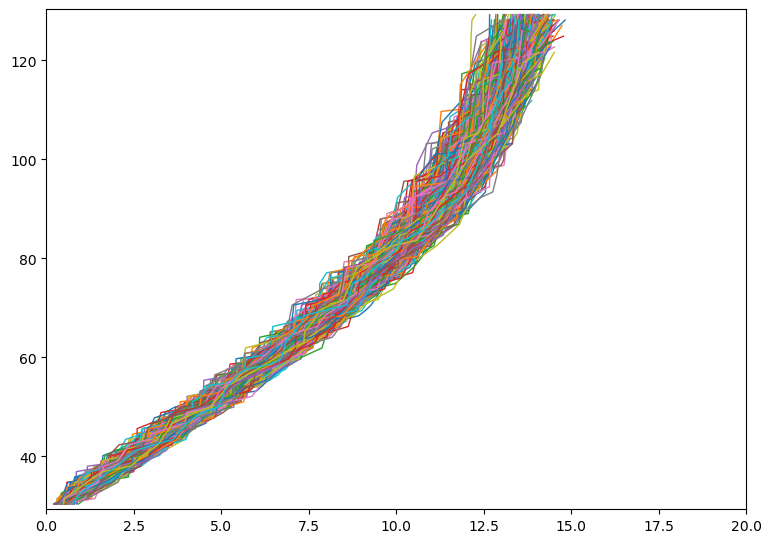

In [10]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, e.macro_params.total_time / 60)
ax.set_ylim((e.macro_params.empty_rows-1)*e.macro_params.grid_node_distance,
           (e.macro_params.rows-1)*e.macro_params.grid_node_distance)
for run in range(e.macro_params.total_trials):
    for j in range(e.macro_params.cols):
        plt.plot(deg_fronts[run][j][0], deg_fronts[run][j][1], linewidth=1)

In [11]:
degraded_percent = np.empty((e.macro_params.total_trials, e.macro_params.number_of_saves), dtype=np.float_)
for r in range(e.macro_params.total_trials):
    for t in range(e.macro_params.number_of_saves):
        degraded_percent[r, t] = np.count_nonzero(mapped_deg[r, t] <= tsave[r, t]) 
degraded_percent -= e.macro_params.empty_rows*e.macro_params.full_row
degraded_percent = degraded_percent / e.macro_params.total_fibers

In [12]:
tolerance = 1e-3
slope = np.empty((e.macro_params.total_trials, e.macro_params.number_of_saves), dtype=np.float_)
for r in range(e.macro_params.total_trials):
    slope[r, 0] = degraded_percent[r, 0]
    for t in range(1, e.macro_params.number_of_saves):
        slope[r, t] = degraded_percent[r, t] - degraded_percent[r, t-1]
degradation_happening = (tolerance <= slope)
degradation_rate = np.empty(e.macro_params.total_trials, dtype=np.float_)
offset = np.empty(e.macro_params.total_trials, dtype=np.float_)
for r in range(e.macro_params.total_trials):
    b, m = np.polynomial.polynomial.polyfit(tsave[r][degradation_happening[r]]/60, 
                                            degraded_percent[r][degradation_happening[r]], 
                                            1)
    degradation_rate[r] = m
    offset[r] = b
print(f"Mean degradation rate: {np.mean(degradation_rate)*100:.3f} percent of fibers per min")
print(f"Standard deviation of degradation rate: {np.std(degradation_rate)*100:.3f} percent of fibers per min")

Mean degradation rate: 7.851 percent of fibers per min
Standard deviation of degradation rate: 0.064 percent of fibers per min


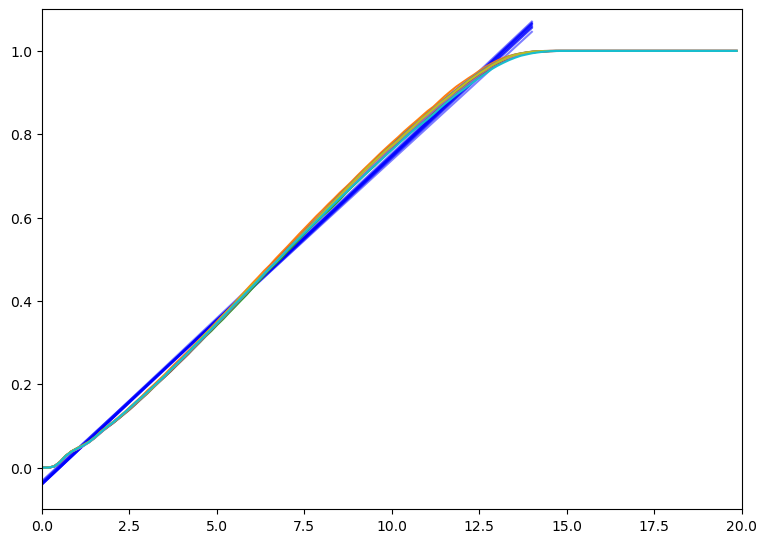

In [13]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_xlim(0, e.macro_params.total_time / 60)
ax.set_ylim(-0.1, 1.1)
for r in range(e.macro_params.total_trials):
    plt.plot(tsave[r]/60, degraded_percent[r])
    plt.plot(np.arange(15)*degradation_rate[r] + offset[r], color='b', alpha=0.5, zorder=0.1)

In [14]:
degradation_rate*100

array([7.84477298, 7.90740689, 7.82791841, 7.78637884, 7.84586407,
       7.89525438, 7.88948009, 7.90350328, 7.91291777, 7.70110627])

In [15]:
print(f"Number of molecules that reached the back row: {np.count_nonzero(mfpt > 0):,}")
print(f"Percent of molecules that reached the back row: {np.count_nonzero(mfpt > 0)/e.macro_params.total_molecules*100:.1f}%")
print(f"Mean time to reach back row: {np.mean(mfpt[mfpt > 0]/60):.3f} minutes")
print(f"Standard deviation of time to reach back row: {np.std(mfpt[mfpt > 0]/60):.3f} minutes")

Number of molecules that reached the back row: 42,361
Percent of molecules that reached the back row: 98.3%
Mean time to reach back row: 12.763 minutes
Standard deviation of time to reach back row: 3.378 minutes
